In [ ]:
import numpy as np
import chess
import chess.pgn
import math
import random
from collections import defaultdict, deque
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import load_model

C_PUCT = 3.0      
model_type = "agressive"
model = load_model(f'{model_type}.keras')

import numpy as np
piece_map = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5
}
def board2tensor_1d(board):
    tensor = np.zeros((12, 64), dtype=np.float32)
    for sq in chess.SQUARES:
        piece = board.piece_at(sq)
        if piece:
            base = piece_map[piece.piece_type]
            if piece.color == chess.BLACK:
                base += 6
            tensor[base, sq] = 1.0
    return tensor.flatten()

class MCTSNode:
    def __init__(self, board, parent=None, eval=0.0):
        self.board = board.copy()
        self.parent = parent
        self.children = {}
        self.prior = eval
        self.N = 0
        self.W = 0.0
        self.Q = 0.0
        self.is_expanded = False

    def expand(self):
        legal_moves = list(self.board.generate_legal_moves())
        turn = 1.0
        if self.board.turn: 
            turn = -1.0

        for move in legal_moves:
            self.board.push(move)
            tensor = board2tensor_1d(self.board).reshape(1, -1)
            eval = model.predict(tensor, verbose=0)[0][0]
            self.children[move] = MCTSNode(self.board, self, eval * turn)
            self.board.pop()

        self.is_expanded = True
        return self.prior

    @staticmethod
    def uct_score(child, parent_N, c_puct=1.5):
        U = c_puct * child.prior * math.sqrt(parent_N + 1e-8) / (1 + child.N)
        return child.Q + U

    def select_child(self):
        parent_N = self.N
        best_move = None
        best_score = -float('inf')

        for move, child in self.children.items():
            score = MCTSNode.uct_score(child, parent_N)
            if score > best_score:
                best_score = score
                best_move = move

        return best_move, self.children[best_move]

    def backpropagate(self, value):
        node = self
        while node is not None:
            node.N += 1
            node.W += value
            node.Q = node.W / node.N
            
            value = -value
            node = node.parent

    def get_policy_value(self):
        policy = self.Q
        if not self.board.turn:  # przywrucenie widoku ze strony białych
            policy *= -1
        return policy


def mcts_search(root, simulations=800):
    for _ in range(simulations):
        node = root

        # Selection
        while node.is_expanded and not node.board.is_game_over():
            move, node = node.select_child()

        # Expansion
        if not node.board.is_game_over():
            value = node.expand()
        else:
            result = node.board.result()
            if result == "1-0":
                value = 1
            elif result == "0-1":
                value = -1
            else:
                value = 0

        # Backpropagation
        node.backpropagate(value)


In [10]:
from collections import deque

def extract_training_data(root):
    queue = deque([root])
    X, Y = [], []

    while queue:
        node = queue.popleft()

        tensor = board2tensor_1d(node.board)
        X.append(tensor)

        # Q-value jako label
        Y.append(node.get_policy_value())

        for child in node.children.values():
            queue.append(child)

    return np.array(X), np.array(Y)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
model = load_model(f'{model_type}.keras')
ITERATIONS = 150
SYMULATIONS = 750

version = 1
historis = []
for iter in range(ITERATIONS):
    root = MCTSNode(chess.Board())
    mcts_search(root, simulations=SYMULATIONS)
    X, Y = extract_training_data(root)

    X = np.array(X)
    Y = np.array(Y).astype(np.float32)
    print("Zebrano przykładów:", X.shape[0])


    X_train, X_val, y_train, y_val = train_test_split(
        X, Y, test_size=0.2, shuffle=True
    )


    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=256,
        verbose=1,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    historis.append(history)
    if((iter + 1) % 100 == 0):
        model.save(f"models/{model_type}_{version}.keras")
        version += 1





Zebrano przykładów: 20392
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.7800e-04 - mae: 0.0151 - val_loss: 1.0482e-05 - val_mae: 0.0023
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6037e-06 - mae: 0.0018 - val_loss: 5.6962e-06 - val_mae: 0.0015
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8728e-06 - mae: 0.0013 - val_loss: 4.2274e-06 - val_mae: 0.0013
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9562e-06 - mae: 0.0012 - val_loss: 3.4004e-06 - val_mae: 0.0012
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6112e-06 - mae: 0.0011 - val_loss: 3.4751e-06 - val_mae: 0.0012
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2659e-06 - mae: 0.0010 - val_loss: 2.8718e-06 - val_mae: 0.0010
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0850e-06 - mae: 9.5499e-04 - val_loss: 4.0908e-06 - val_mae: 0.0015
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2002e-06 - mae: 9.9821e-04 - val_loss: 2.

2025-12-18 00:42:31.896813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 00:42:32.166026: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 00:42:32.242745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 00:42:32.307823: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 00:42:32.353218: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0012 - mae: 0.0209 - val_loss: 3.7291e-05 - val_mae: 0.0051
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0088e-05 - mae: 0.0021 - val_loss: 4.7920e-06 - val_mae: 0.0014
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2197e-06 - mae: 0.0013 - val_loss: 3.5640e-06 - val_mae: 0.0012
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1429e-06 - mae: 0.0012 - val_loss: 2.9565e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6075e-06 - mae: 0.0010 - val_loss: 2.6445e-06 - val_mae: 0.0010
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3086e-06 - mae: 9.7590e-04 - val_loss: 2.2987e-06 - val_mae: 9.4044e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1577e-06 - mae: 9.4776e-04 - val_loss: 2.2581e-06 - val_mae: 9.5451e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9960e-06 - mae: 8.9901e-04 - val_loss: 2.0530e-06 - val_mae: 8.7637e-0

2025-12-18 00:52:17.238337: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 68 bytes spill stores, 68 bytes spill loads

2025-12-18 00:52:17.261185: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 00:52:17.437869: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 524 bytes spill stores, 524 bytes spill loads



53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.6258e-04 - mae: 0.0180 - val_loss: 1.3526e-05 - val_mae: 0.0025
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0108e-06 - mae: 0.0018 - val_loss: 3.8148e-06 - val_mae: 0.0012
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4746e-06 - mae: 0.0011 - val_loss: 2.5491e-06 - val_mae: 0.0010
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8399e-06 - mae: 9.4296e-04 - val_loss: 2.2114e-06 - val_mae: 0.0010
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5178e-06 - mae: 8.6665e-04 - val_loss: 1.9134e-06 - val_mae: 8.9716e-04
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2930e-06 - mae: 8.0732e-04 - val_loss: 1.6877e-06 - val_mae: 8.5924e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1468e-06 - mae: 7.6172e-04 - val_loss: 1.4527e-06 - val_mae: 7.6242e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8849e-07 - mae: 7.0385e-04 - val_loss: 1.5008e-06 - va

2025-12-18 01:22:34.183439: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-18 01:22:34.202116: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 100 bytes spill stores, 100 bytes spill loads

2025-12-18 01:22:34.344763: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 660 bytes spill stores, 660 bytes spill loads

2025-12-18 01:22:34.349324: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 216 bytes spill stores, 216 bytes spill loads

2025-12-18 01:22:34.397125: I extern

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0010 - mae: 0.0204 - val_loss: 4.2383e-05 - val_mae: 0.0058
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6735e-06 - mae: 0.0022 - val_loss: 4.2818e-06 - val_mae: 0.0014
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4151e-06 - mae: 0.0011 - val_loss: 2.8501e-06 - val_mae: 0.0010
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8231e-06 - mae: 9.7604e-04 - val_loss: 2.4353e-06 - val_mae: 9.7066e-04
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4616e-06 - mae: 8.7529e-04 - val_loss: 2.0822e-06 - val_mae: 8.8161e-04
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2618e-06 - mae: 8.0332e-04 - val_loss: 1.8767e-06 - val_mae: 8.3299e-04
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1145e-06 - mae: 7.5499e-04 - val_loss: 1.7657e-06 - val_mae: 7.9022e-04
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0268e-06 - mae: 7.2786e-04 - val_loss: 1.7094e-06 - va

2025-12-18 01:42:39.024608: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 64 bytes spill stores, 64 bytes spill loads

2025-12-18 01:42:39.224749: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - mae: 0.0275

2025-12-18 01:42:40.240100: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 01:42:40.245887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 01:42:40.308469: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 01:42:40.405437: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-18 01:42:40.421535: I external/l

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.8004e-04 - mae: 0.0162 - val_loss: 1.9465e-05 - val_mae: 0.0034
Epoch 2/10
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1487e-05 - mae: 0.0024 

2025-12-18 01:42:40.809043: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1625e-06 - mae: 0.0019 - val_loss: 5.6823e-06 - val_mae: 0.0016
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9636e-06 - mae: 0.0014 - val_loss: 4.7094e-06 - val_mae: 0.0014
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9820e-06 - mae: 0.0012 - val_loss: 3.5353e-06 - val_mae: 0.0011
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4759e-06 - mae: 0.0011 - val_loss: 4.1759e-06 - val_mae: 0.0014
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1658e-06 - mae: 0.0010 - val_loss: 2.9314e-06 - val_mae: 9.9884e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9794e-06 - mae: 9.7172e-04 - val_loss: 5.2384e-06 - val_mae: 0.0016
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5015e-06 - mae: 0.0011 - val_loss: 2.6957e-06 - val_mae: 9.6524e-04
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6434e-06 - mae: 8.7444e-04 - val_loss: 2.7525e-06 - val_mae: 9.8953e-04

2025-12-18 02:02:36.442681: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 02:02:36.497301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 02:02:36.786094: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 02:02:36.787909: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 440 bytes spill stores, 440 bytes spill loads

2025-12-18 02:02:36.794633: I external

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0028 - mae: 0.0354

2025-12-18 02:02:38.538253: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 02:02:38.562933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 02:02:38.639516: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 02:02:38.730754: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-18 02:02:38.759213: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0011 - mae: 0.0205 - val_loss: 2.8170e-05 - val_mae: 0.0042
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0755e-05 - mae: 0.0022 - val_loss: 8.0804e-06 - val_mae: 0.0017
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7316e-06 - mae: 0.0015 - val_loss: 6.4561e-06 - val_mae: 0.0015
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5634e-06 - mae: 0.0013 - val_loss: 5.8283e-06 - val_mae: 0.0014
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9086e-06 - mae: 0.0012 - val_loss: 5.2453e-06 - val_mae: 0.0013
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5215e-06 - mae: 0.0012 - val_loss: 5.0361e-06 - val_mae: 0.0013
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1524e-06 - mae: 0.0011 - val_loss: 4.4907e-06 - val_mae: 0.0012
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0189e-06 - mae: 0.0011 - val_loss: 4.8918e-06 - val_mae: 0.0013
Epoch 9/10
55/55 ━━━━━

2025-12-18 02:12:36.939137: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-18 02:12:36.986044: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-18 02:12:37.072918: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-18 02:12:37.072944: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-18 02:12:37.112076: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0023 - mae: 0.0323

2025-12-18 02:12:38.278632: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 02:12:38.334324: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-18 02:12:38.505644: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 02:12:38.508180: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-18 02:12:38.682187: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 9.5628e-04 - mae: 0.0193 - val_loss: 2.7043e-05 - val_mae: 0.0044
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9526e-06 - mae: 0.0018 - val_loss: 4.3554e-06 - val_mae: 0.0014
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9011e-06 - mae: 0.0012 - val_loss: 3.5407e-06 - val_mae: 0.0012
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2889e-06 - mae: 0.0010 - val_loss: 3.1100e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9624e-06 - mae: 9.5303e-04 - val_loss: 3.0378e-06 - val_mae: 0.0010
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7591e-06 - mae: 8.8833e-04 - val_loss: 2.6733e-06 - val_mae: 9.4281e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5782e-06 - mae: 8.2196e-04 - val_loss: 2.5767e-06 - val_mae: 9.0106e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5744e-06 - mae: 8.2349e-04 - val_loss: 2.5835e-06 - val_mae: 9

2025-12-18 02:32:02.650785: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-18 02:32:02.710783: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 100 bytes spill stores, 100 bytes spill loads

2025-12-18 02:32:02.728440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-18 02:32:02.764012: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 212 bytes spill stores, 212 bytes spill loads

2025-12-18 02:32:02.827021: I external

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 8.0128e-04 - mae: 0.0174 - val_loss: 1.9037e-05 - val_mae: 0.0036
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0477e-06 - mae: 0.0017 - val_loss: 3.5870e-06 - val_mae: 0.0012
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7698e-06 - mae: 0.0011 - val_loss: 2.8229e-06 - val_mae: 0.0011
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9984e-06 - mae: 9.7055e-04 - val_loss: 2.3524e-06 - val_mae: 9.5493e-04
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6543e-06 - mae: 8.7716e-04 - val_loss: 2.3077e-06 - val_mae: 0.0010
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3871e-06 - mae: 8.1553e-04 - val_loss: 2.0445e-06 - val_mae: 8.8830e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2579e-06 - mae: 7.7772e-04 - val_loss: 1.9740e-06 - val_mae: 8.9425e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1587e-06 - mae: 7.5019e-04 - val_loss: 1.8696e-06 - va

2025-12-18 02:42:58.936328: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 02:42:58.973458: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 02:42:59.007829: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 02:42:59.157296: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 02:42:59.191009: I external/local

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.4366e-04 - mae: 0.0156 - val_loss: 2.2116e-05 - val_mae: 0.0035
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2770e-06 - mae: 0.0018 - val_loss: 7.7273e-06 - val_mae: 0.0014
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9583e-06 - mae: 0.0013 - val_loss: 6.7162e-06 - val_mae: 0.0013
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2896e-06 - mae: 0.0012 - val_loss: 6.6763e-06 - val_mae: 0.0013
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6866e-06 - mae: 0.0010 - val_loss: 6.7531e-06 - val_mae: 0.0013
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4114e-06 - mae: 0.0010 - val_loss: 6.6597e-06 - val_mae: 0.0014
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3091e-06 - mae: 9.9628e-04 - val_loss: 5.9121e-06 - val_mae: 0.0013
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2440e-06 - mae: 9.7720e-04 - val_loss: 5.4504e-06 - val_mae: 0.0011
Epoch 9/10

2025-12-18 03:13:00.153808: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 03:13:00.429074: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-18 03:13:00.598490: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 424 bytes spill stores, 424 bytes spill loads

2025-12-18 03:13:00.605866: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-18 03:13:00.618745: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 8.2914e-04 - mae: 0.0180 - val_loss: 1.9330e-05 - val_mae: 0.0034
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4108e-06 - mae: 0.0018 - val_loss: 4.5777e-06 - val_mae: 0.0012
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4709e-06 - mae: 0.0011 - val_loss: 3.9377e-06 - val_mae: 0.0012
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8862e-06 - mae: 9.3668e-04 - val_loss: 3.0700e-06 - val_mae: 9.5606e-04
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5691e-06 - mae: 8.3930e-04 - val_loss: 2.7723e-06 - val_mae: 9.0797e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4555e-06 - mae: 8.1943e-04 - val_loss: 2.6302e-06 - val_mae: 8.9523e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2879e-06 - mae: 7.6463e-04 - val_loss: 2.4537e-06 - val_mae: 8.1181e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1455e-06 - mae: 7.0844e-04 - val_loss: 2.4042e-06 

2025-12-18 03:33:06.925163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 03:33:07.100339: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 03:33:07.138386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-18 03:33:07.157853: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-18 03:33:07.172272: I external/local

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 9.4184e-04 - mae: 0.0189 - val_loss: 1.7809e-05 - val_mae: 0.0033
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0028e-05 - mae: 0.0022 - val_loss: 5.7913e-06 - val_mae: 0.0016
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3188e-06 - mae: 0.0014 - val_loss: 4.1516e-06 - val_mae: 0.0013
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1544e-06 - mae: 0.0012 - val_loss: 4.3656e-06 - val_mae: 0.0014
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6092e-06 - mae: 0.0011 - val_loss: 2.9570e-06 - val_mae: 0.0010
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2546e-06 - mae: 9.9501e-04 - val_loss: 2.7681e-06 - val_mae: 0.0010
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0991e-06 - mae: 9.5950e-04 - val_loss: 2.8745e-06 - val_mae: 0.0010
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8863e-06 - mae: 9.0436e-04 - val_loss: 2.4794e-06 - val_mae: 9.5213e-04
Ep

2025-12-18 03:43:35.467903: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-18 03:43:35.603810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 424 bytes spill stores, 424 bytes spill loads

2025-12-18 03:43:35.627818: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-18 03:43:35.674822: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-18 03:43:35.679542: I external/l

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0010 - mae: 0.0196 - val_loss: 1.1720e-05 - val_mae: 0.0022
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1948e-05 - mae: 0.0022 - val_loss: 7.1364e-06 - val_mae: 0.0015
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7789e-06 - mae: 0.0014 - val_loss: 7.4064e-06 - val_mae: 0.0013
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4515e-06 - mae: 0.0013 - val_loss: 6.6229e-06 - val_mae: 0.0013
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7863e-06 - mae: 0.0012 - val_loss: 6.0294e-06 - val_mae: 0.0013
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4215e-06 - mae: 0.0012 - val_loss: 5.5136e-06 - val_mae: 0.0011
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3617e-06 - mae: 0.0012 - val_loss: 6.1516e-06 - val_mae: 0.0014
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9944e-06 - mae: 0.0012 - val_loss: 5.2391e-06 - val_mae: 0.0011
Epoch 9/10
56/56 ━━━━━

2025-12-18 04:03:17.702250: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 04:03:17.913875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 04:03:18.088504: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 444 bytes spill stores, 444 bytes spill loads

2025-12-18 04:03:18.090116: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 04:03:18.117068: I external

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0024 - mae: 0.0326

2025-12-18 04:03:19.805276: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 04:03:19.845226: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 04:03:19.961642: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 04:03:20.084945: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-18 04:03:20.092510: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 9.8445e-04 - mae: 0.0196 - val_loss: 1.9249e-05 - val_mae: 0.0036
Epoch 2/10
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3305e-05 - mae: 0.0028 

2025-12-18 04:03:20.395008: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0012e-06 - mae: 0.0021 - val_loss: 3.2225e-06 - val_mae: 0.0013
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7625e-06 - mae: 0.0012 - val_loss: 2.7077e-06 - val_mae: 0.0012
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9856e-06 - mae: 0.0010 - val_loss: 1.8410e-06 - val_mae: 9.7300e-04
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6461e-06 - mae: 9.2007e-04 - val_loss: 1.5724e-06 - val_mae: 8.9500e-04
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6354e-06 - mae: 9.4910e-04 - val_loss: 1.7647e-06 - val_mae: 9.9253e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2624e-06 - mae: 7.9705e-04 - val_loss: 1.2362e-06 - val_mae: 7.6150e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1561e-06 - mae: 7.6965e-04 - val_loss: 1.2047e-06 - val_mae: 7.6422e-04
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0136e-06 - mae: 7.0914e-04 - val_loss: 1.3029e-

2025-12-18 04:33:34.006746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 100 bytes spill stores, 100 bytes spill loads

2025-12-18 04:33:34.018740: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 60 bytes spill stores, 60 bytes spill loads

2025-12-18 04:33:34.091538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-18 04:33:34.094358: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 180 bytes spill stores, 180 bytes spill loads

2025-12-18 04:33:34.106821: I external

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - mae: 0.0260

2025-12-18 04:33:35.281950: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 04:33:35.287092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 04:33:35.391849: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 04:33:35.466500: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-18 04:33:35.474181: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 6.0689e-04 - mae: 0.0156 - val_loss: 2.6675e-05 - val_mae: 0.0043
Epoch 2/10
 1/54 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0263e-05 - mae: 0.0046

2025-12-18 04:33:35.703609: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 924 bytes spill stores, 924 bytes spill loads

2025-12-18 04:33:35.761366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8474e-06 - mae: 0.0017 - val_loss: 3.2004e-06 - val_mae: 0.0012
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0814e-06 - mae: 0.0010 - val_loss: 2.2720e-06 - val_mae: 9.6492e-04
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4622e-06 - mae: 8.5876e-04 - val_loss: 2.2883e-06 - val_mae: 0.0010
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2934e-06 - mae: 8.2954e-04 - val_loss: 1.8939e-06 - val_mae: 8.5318e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0329e-06 - mae: 7.2972e-04 - val_loss: 1.5559e-06 - val_mae: 7.5122e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3481e-07 - mae: 7.0560e-04 - val_loss: 1.6852e-06 - val_mae: 8.0774e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4429e-07 - mae: 6.6789e-04 - val_loss: 1.3705e-06 - val_mae: 6.9884e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5870e-07 - mae: 6.3133e-04 - val_loss: 1.34

2025-12-18 04:54:52.812609: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-18 04:54:52.985145: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-18 04:54:52.990322: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-18 04:54:52.991094: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 04:54:53.067911: I external/loc

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0021 - mae: 0.0305

2025-12-18 04:54:54.348550: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 04:54:54.399329: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 04:54:54.449055: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 04:54:54.603018: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-18 04:54:54.614846: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 8.6770e-04 - mae: 0.0185 - val_loss: 1.6709e-05 - val_mae: 0.0032
Epoch 2/10


2025-12-18 04:54:54.922414: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5204e-06 - mae: 0.0021 - val_loss: 3.7969e-06 - val_mae: 0.0013
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9519e-06 - mae: 0.0012 - val_loss: 2.9375e-06 - val_mae: 0.0012
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3074e-06 - mae: 0.0011 - val_loss: 2.5375e-06 - val_mae: 0.0011
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8742e-06 - mae: 9.6649e-04 - val_loss: 2.2539e-06 - val_mae: 0.0010
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6630e-06 - mae: 9.0477e-04 - val_loss: 2.0033e-06 - val_mae: 9.3273e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6108e-06 - mae: 9.0657e-04 - val_loss: 1.6682e-06 - val_mae: 8.3506e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3041e-06 - mae: 7.8080e-04 - val_loss: 1.6791e-06 - val_mae: 8.2331e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3345e-06 - mae: 8.1075e-04 - val_loss: 1.6009e-06 - val

2025-12-18 05:15:05.727192: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 05:15:05.761082: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 05:15:05.842530: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 05:15:05.968132: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-18 05:15:05.985316: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0010 - mae: 0.0193 - val_loss: 3.0956e-05 - val_mae: 0.0046
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7033e-06 - mae: 0.0021 - val_loss: 7.0106e-06 - val_mae: 0.0015
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0731e-06 - mae: 0.0013 - val_loss: 5.6235e-06 - val_mae: 0.0013
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5192e-06 - mae: 0.0011 - val_loss: 5.2567e-06 - val_mae: 0.0012
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1504e-06 - mae: 0.0011 - val_loss: 4.9443e-06 - val_mae: 0.0012
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0929e-06 - mae: 0.0010 - val_loss: 5.1140e-06 - val_mae: 0.0012
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0755e-06 - mae: 0.0011 - val_loss: 4.5282e-06 - val_mae: 0.0010
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5254e-06 - mae: 9.2309e-04 - val_loss: 4.1158e-06 - val_mae: 9.3168e-04
Epoch 9/10
55/

2025-12-18 05:44:57.871428: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 05:44:58.186229: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 64 bytes spill stores, 64 bytes spill loads

2025-12-18 05:44:58.291314: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 05:44:58.316160: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 524 bytes spill stores, 524 bytes spill loads

2025-12-18 05:44:58.362435: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.5754e-04 - mae: 0.0174 - val_loss: 1.8343e-05 - val_mae: 0.0032
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2794e-06 - mae: 0.0019 - val_loss: 5.3113e-06 - val_mae: 0.0013
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9683e-06 - mae: 0.0011 - val_loss: 4.4671e-06 - val_mae: 0.0012
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2366e-06 - mae: 0.0010 - val_loss: 3.9657e-06 - val_mae: 0.0011
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8877e-06 - mae: 9.2530e-04 - val_loss: 3.8691e-06 - val_mae: 0.0011
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7262e-06 - mae: 8.8832e-04 - val_loss: 3.4340e-06 - val_mae: 9.4430e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4018e-06 - mae: 7.9965e-04 - val_loss: 3.0861e-06 - val_mae: 8.5233e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2962e-06 - mae: 7.6162e-04 - val_loss: 3.0239e-06 - val_mae: 9

2025-12-18 05:54:55.965232: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 05:54:55.975010: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 05:54:56.108046: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 05:54:56.368766: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 240 bytes spill stores, 240 bytes spill loads

2025-12-18 05:54:56.396825: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.4369e-04 - mae: 0.0141 - val_loss: 1.2272e-05 - val_mae: 0.0028
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8972e-06 - mae: 0.0016 - val_loss: 2.7860e-06 - val_mae: 0.0011
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9962e-06 - mae: 9.9844e-04 - val_loss: 2.1462e-06 - val_mae: 9.4985e-04
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5417e-06 - mae: 8.9196e-04 - val_loss: 1.9081e-06 - val_mae: 8.8234e-04
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2568e-06 - mae: 8.1922e-04 - val_loss: 1.6281e-06 - val_mae: 7.8527e-04
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0156e-06 - mae: 7.3228e-04 - val_loss: 1.5441e-06 - val_mae: 7.6452e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0253e-06 - mae: 7.5171e-04 - val_loss: 1.5099e-06 - val_mae: 7.5310e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0213e-06 - mae: 7.6557e-04 - val_loss: 1.8

2025-12-18 06:48:15.196349: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 06:48:15.373385: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 56 bytes spill stores, 56 bytes spill loads

2025-12-18 06:48:15.512428: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 06:48:15.560136: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-18 06:48:15.574522: I external/l

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.8874e-04 - mae: 0.0182 - val_loss: 2.8110e-05 - val_mae: 0.0047
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0324e-06 - mae: 0.0018 - val_loss: 2.9675e-06 - val_mae: 0.0012
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1217e-06 - mae: 0.0011 - val_loss: 2.3607e-06 - val_mae: 0.0010
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6392e-06 - mae: 9.2701e-04 - val_loss: 1.9998e-06 - val_mae: 9.3417e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3771e-06 - mae: 8.4816e-04 - val_loss: 1.7500e-06 - val_mae: 8.5619e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1700e-06 - mae: 7.7212e-04 - val_loss: 1.6250e-06 - val_mae: 8.3118e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1065e-06 - mae: 7.6212e-04 - val_loss: 1.7193e-06 - val_mae: 8.8136e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8749e-07 - mae: 7.0474e-04 - val_loss: 1.3947e-06 

2025-12-18 08:01:02.301108: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 08:01:02.417234: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 08:01:02.452324: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 08:01:02.466693: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-18 08:01:02.631632: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0020 - mae: 0.0302

2025-12-18 08:01:04.405995: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-18 08:01:04.419055: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-18 08:01:04.499267: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-18 08:01:04.589931: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-18 08:01:04.659699: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 8.3840e-04 - mae: 0.0182 - val_loss: 1.0999e-05 - val_mae: 0.0026
Epoch 2/10
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4144e-06 - mae: 0.0024 

2025-12-18 08:01:04.934994: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6195e-06 - mae: 0.0017 - val_loss: 2.5586e-06 - val_mae: 0.0011
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0090e-06 - mae: 0.0010 - val_loss: 2.0663e-06 - val_mae: 0.0010
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6194e-06 - mae: 9.0109e-04 - val_loss: 1.6014e-06 - val_mae: 8.6973e-04
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4022e-06 - mae: 8.4127e-04 - val_loss: 1.3561e-06 - val_mae: 8.0928e-04
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1641e-06 - mae: 7.5337e-04 - val_loss: 1.2064e-06 - val_mae: 7.4339e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0552e-06 - mae: 7.1710e-04 - val_loss: 1.3393e-06 - val_mae: 8.0107e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0800e-06 - mae: 7.4225e-04 - val_loss: 1.0931e-06 - val_mae: 7.1836e-04
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4973e-07 - mae: 6.7292e-04 - val_loss: 9.97

KeyboardInterrupt: 

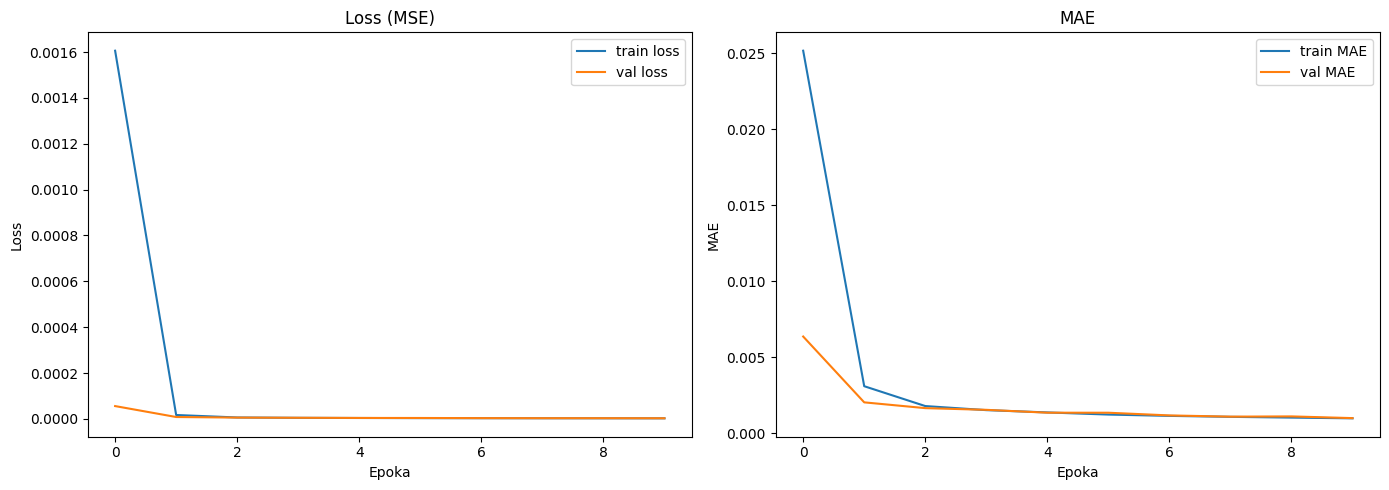

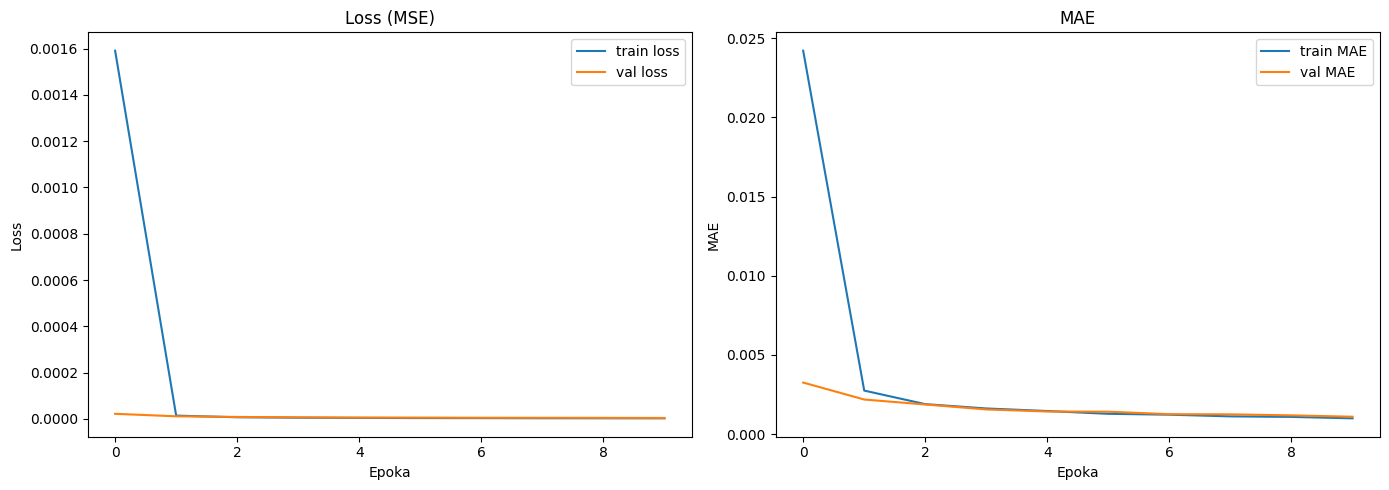

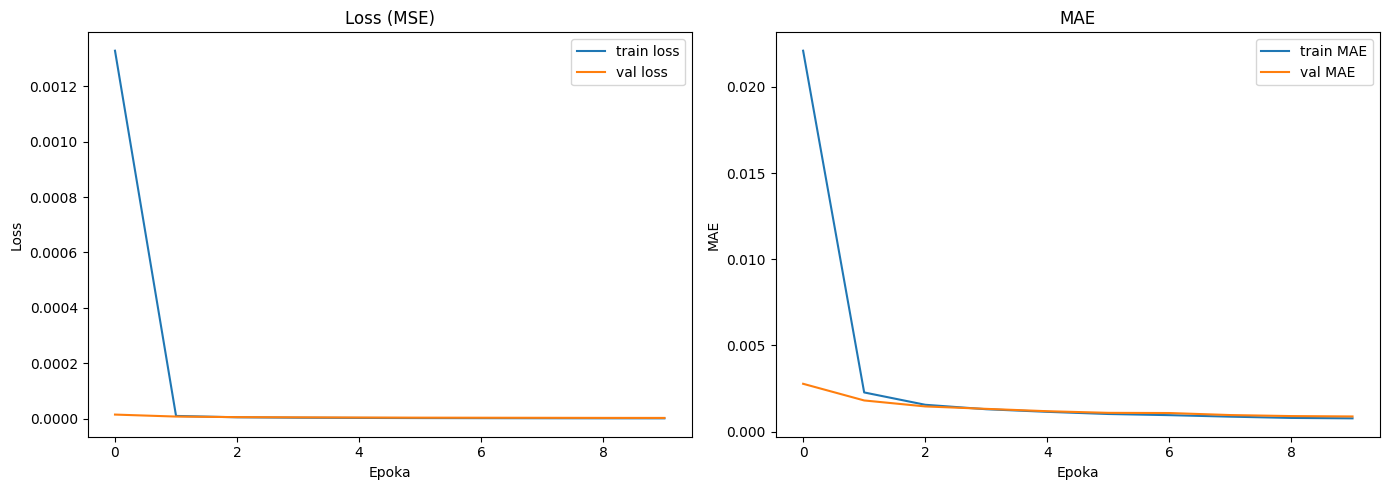

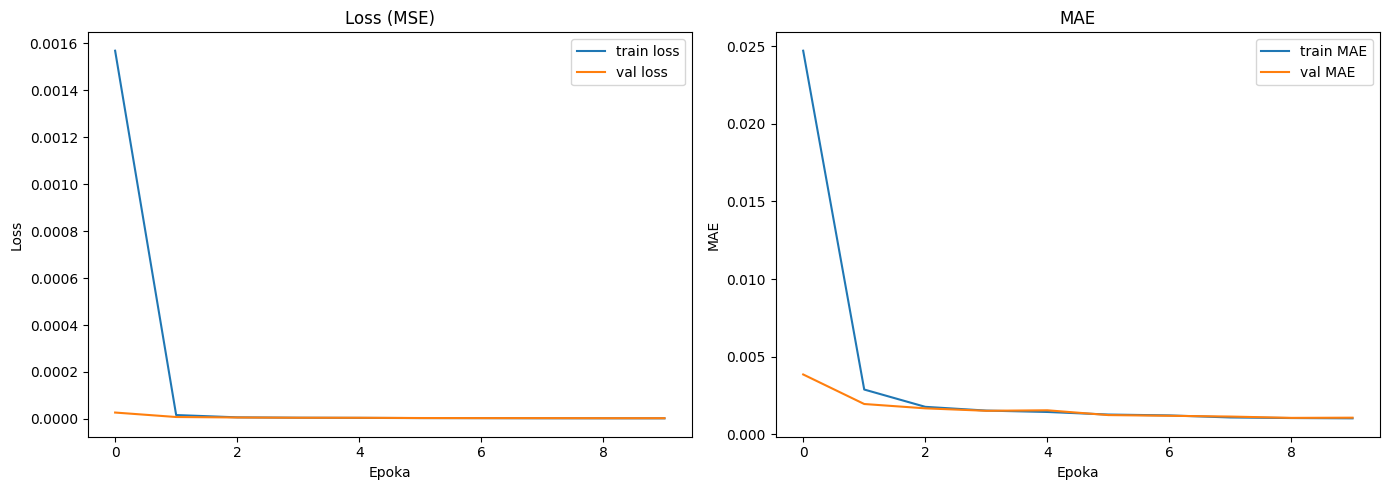

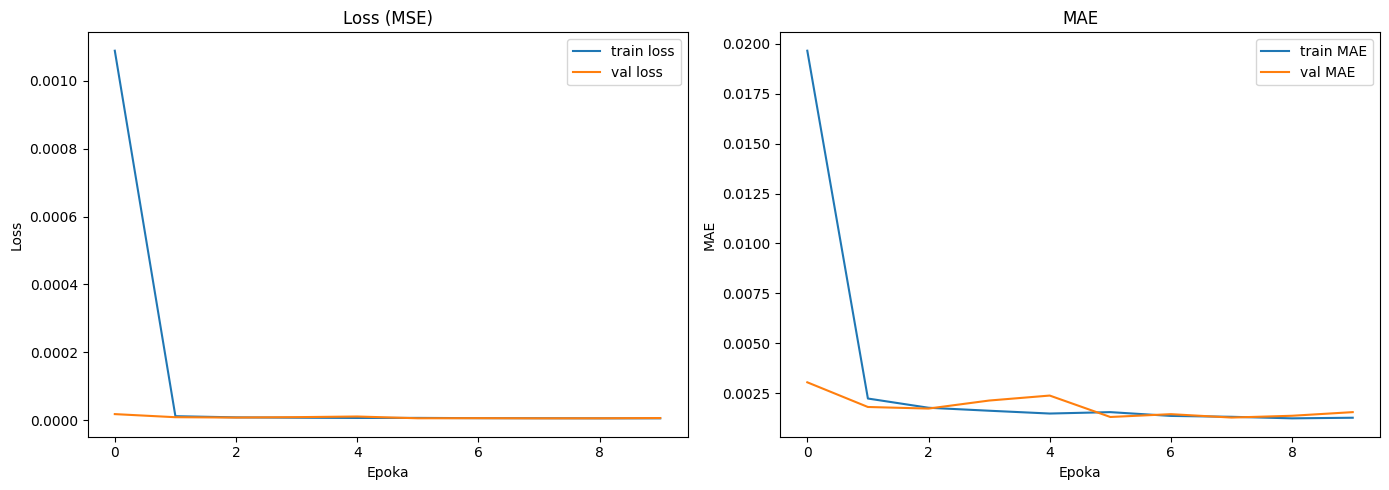

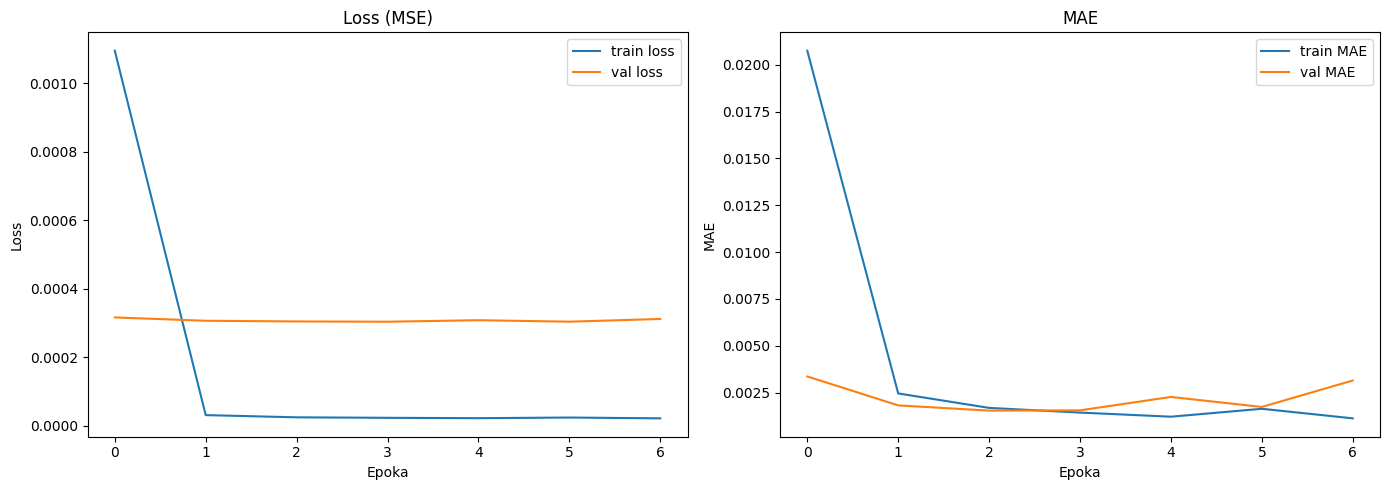

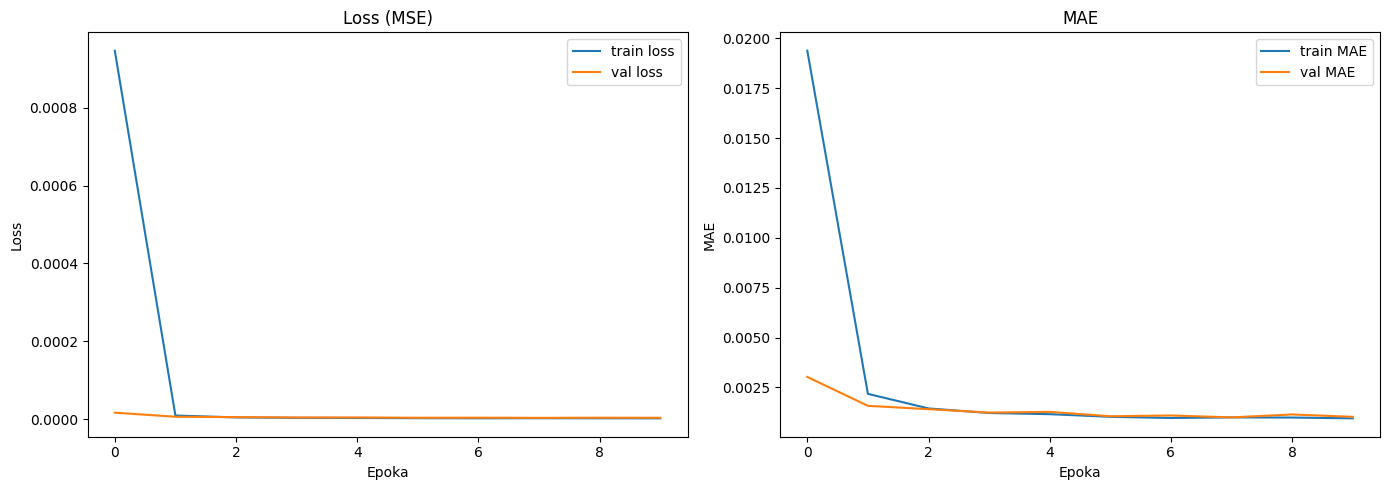

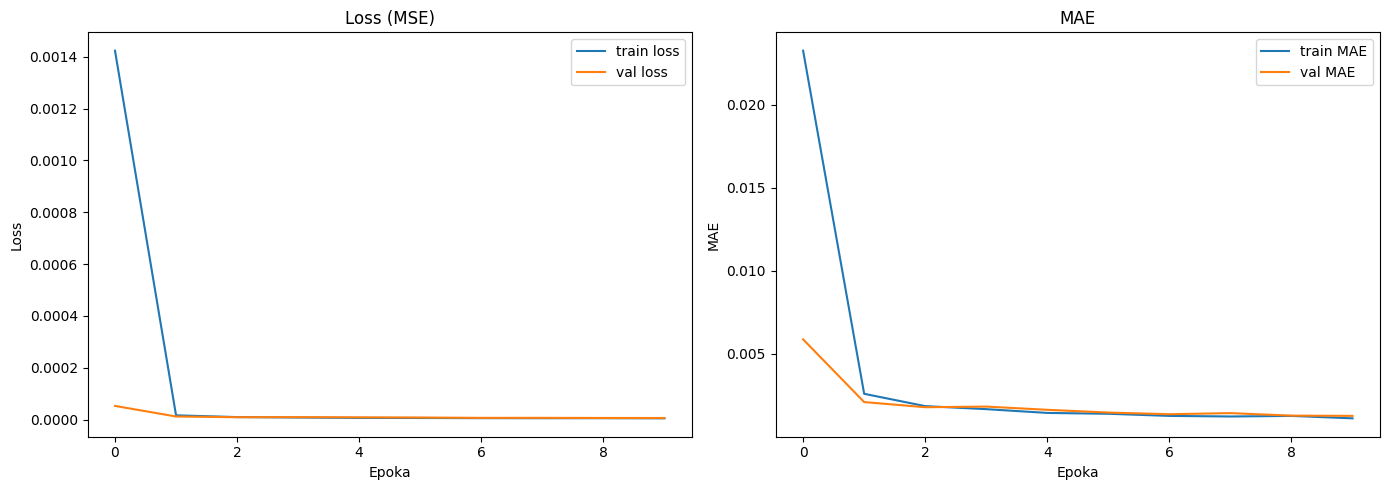

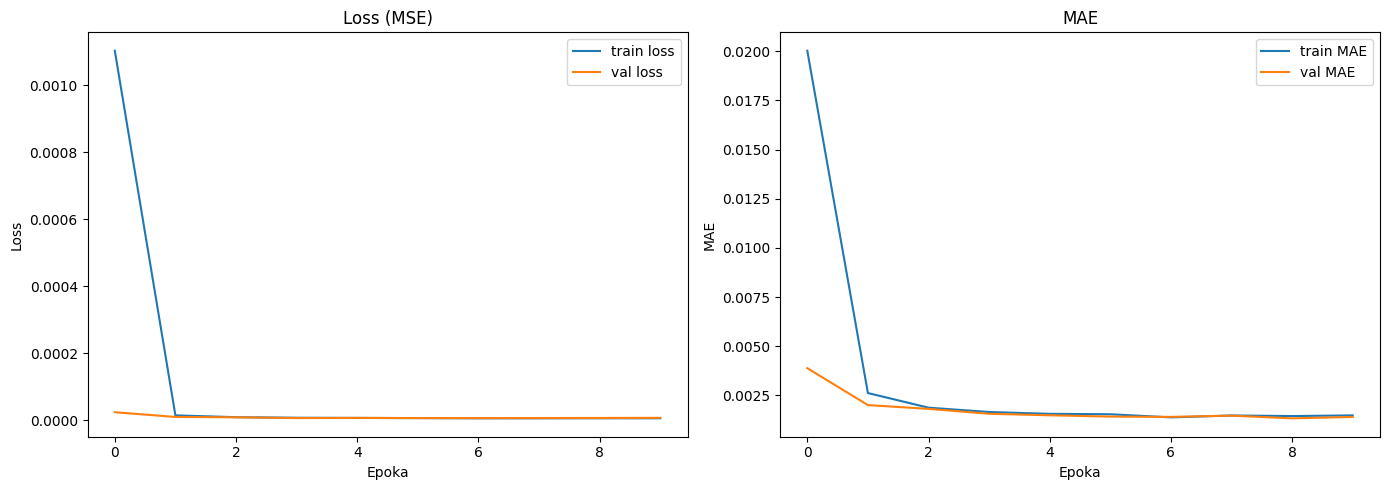

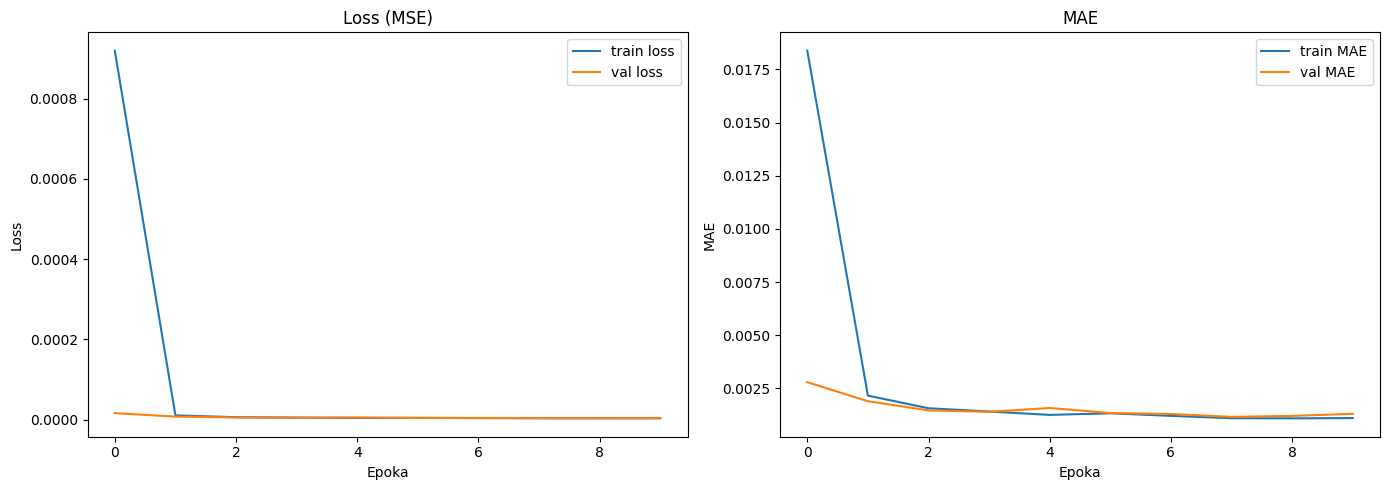

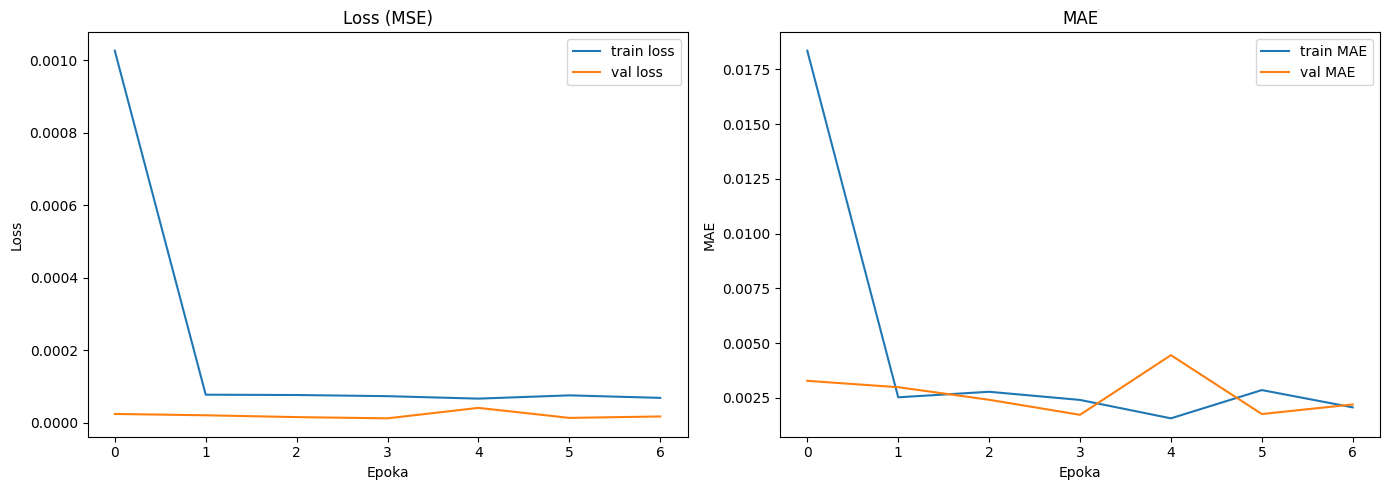

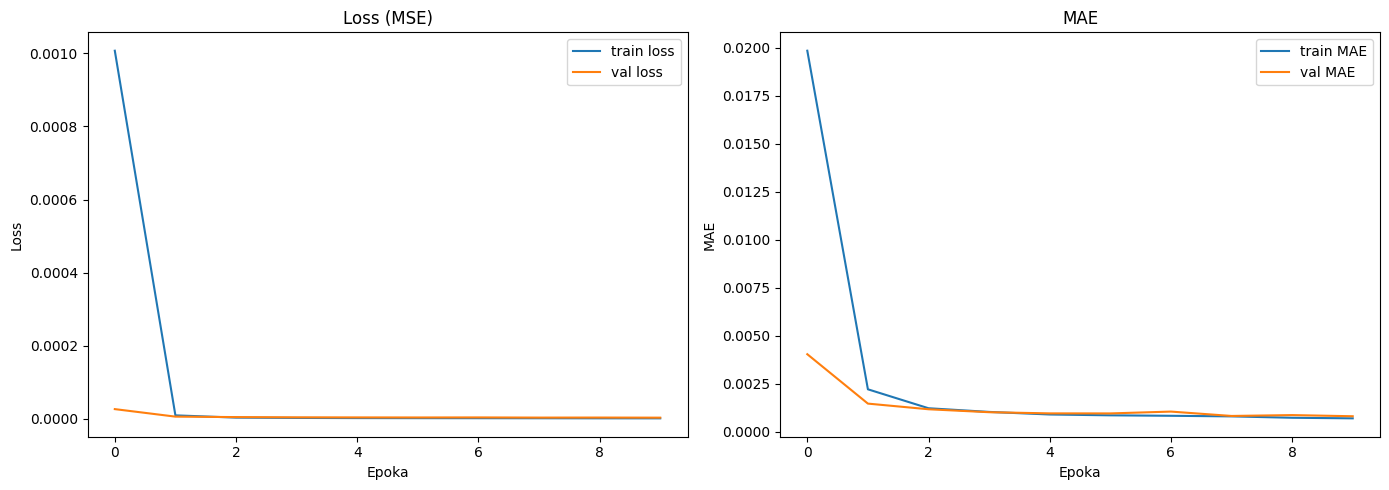

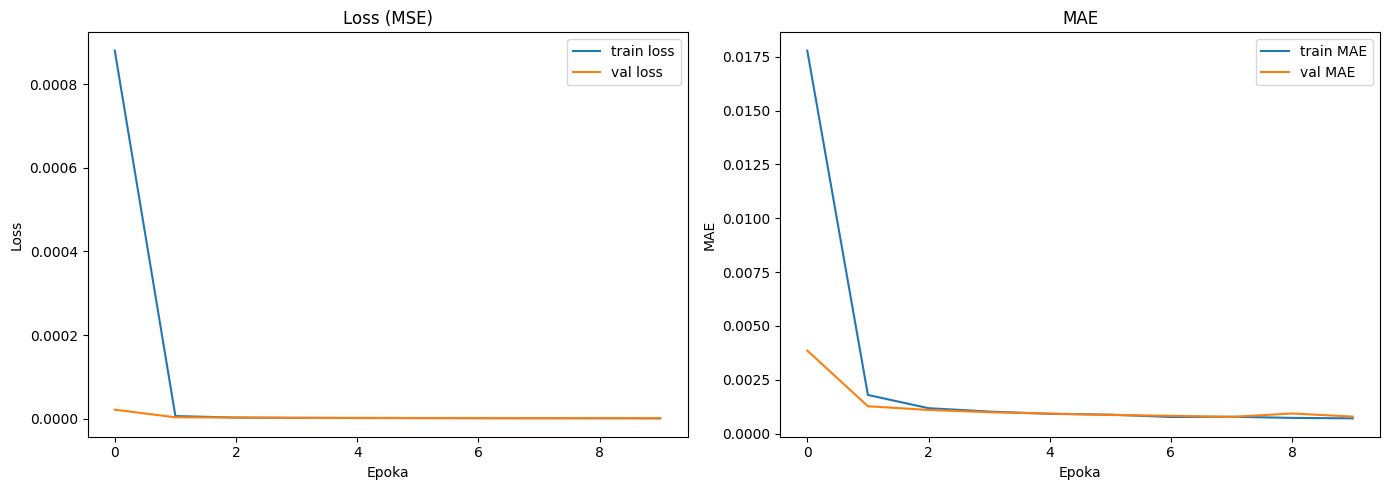

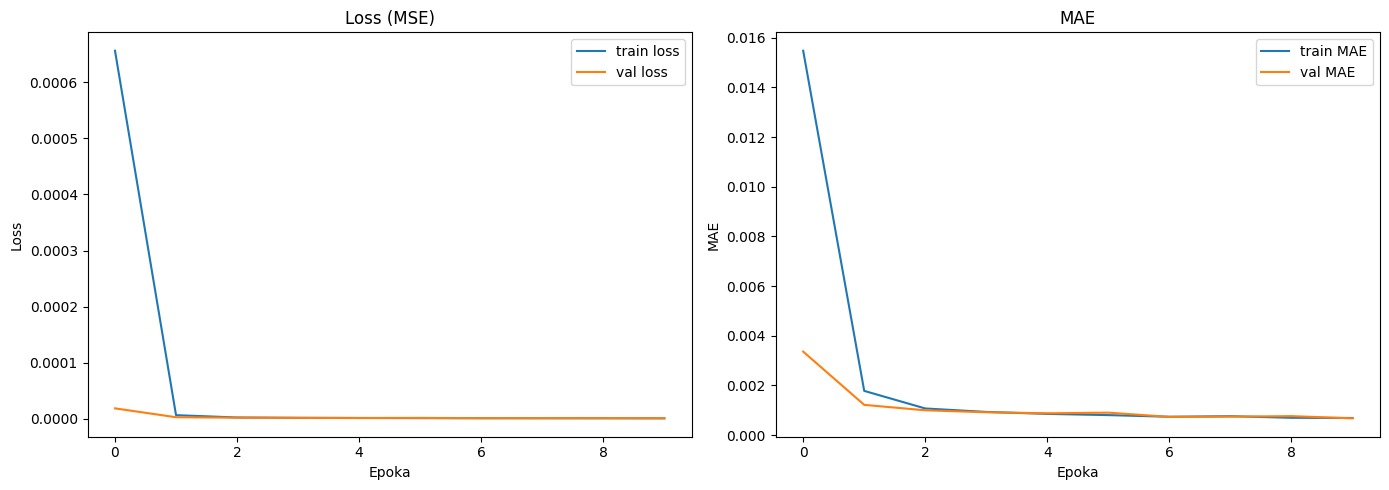

In [ ]:
for i in range(1,15):
    history = historis[100 * i]
    plt.figure(figsize=(14,5))
    # ------ Loss ---------
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title("Loss (MSE)")
    plt.xlabel("Epoka")
    plt.ylabel("Loss")
    plt.legend()

    # ------ MAE ----------
    plt.subplot(1,2,2)
    plt.plot(history.history["mae"], label="train MAE")
    plt.plot(history.history["val_mae"], label="val MAE")
    plt.title("MAE")
    plt.xlabel("Epoka")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()